In [1]:
!pip install -q --upgrade transformers huggingface-hub datasets==3.6.0

In [2]:
import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import random
load_dotenv(override = True)

True

In [3]:
plt.style.use("fivethirtyeight")

In [4]:
! pip install -q --upgrade datasets==3.6.0

In [5]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Appliances", split="full", trust_remote_code=True)

In [6]:
print(len(dataset))

94327


In [7]:
dataset

Dataset({
    features: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together', 'subtitle', 'author'],
    num_rows: 94327
})

In [8]:
dataset[6]

{'main_category': 'Appliances',
 'title': 'WD12X10327 Rack Roller and stud assembly Kit (4 Pack) by AMI PARTS Replaces AP4980629 PS3486910 1811003',
 'average_rating': 4.6,
 'rating_number': 323,
 'features': ['【PARTS NUMBER】The WD12X10327 dishwasher top rack wheels and stud assembly Kit （4 pcs）',
  '【SCOPE OF APPLICATION】The dishwasher works with most top name brands,If you are not sure if part is correct, ask us in Customer questions & answers section or visiting the AMI PARTS storefront.We’re happy to help ensure you select the correct part for your Rack Roller and stud',
  '【REPLACES PART】1811003, AP4980629, WD12X0330, WD12X0356, WD12X0357, WD12X0383, WD12X0385, WD12X10327, WD12X330, WD12X356, WD12X357, WD12X383, WD12X385',
  '【FIXES SYMPTOMS】Door won’t close | Not cleaning dishes properly | Noisy | Door latch failure',
  '【QUALITY WARRANTY】The replacement part is made from durable high quality material and well-tested by manufacturer.For any reason you’re not satisfied,you can ask

### lets find a maximum price product

In [9]:
max_price = 0.0
max_item = None
for item in tqdm(dataset):
    try:
        price = item['price']
        if price is not None:
            if float(price)  > max_price:
                max_price = float(price)
                max_item = item
    except ValueError:
        pass


  0%|          | 0/94327 [00:00<?, ?it/s]

In [10]:
max_price

21095.62

In [11]:
max_item

{'main_category': 'Appliances',
 'title': 'TurboChef BULLET Rapid Cook Electric Microwave Convection Oven',
 'average_rating': 1.0,
 'rating_number': 1,
 'features': [],
 'description': [],
 'price': '21095.62',
 'images': {'hi_res': ['https://m.media-amazon.com/images/I/61oZOVndavL._AC_SL1000_.jpg'],
  'large': ['https://m.media-amazon.com/images/I/41rIxEeZKjL._AC_.jpg'],
  'thumb': ['https://m.media-amazon.com/images/I/41rIxEeZKjL._AC_SR38,50_.jpg'],
  'variant': ['MAIN']},
 'videos': {'title': [], 'url': [], 'user_id': []},
 'store': 'TurboChef',
 'categories': [],
 'details': '{"Brand Name": "TurboChef", "Energy Use": "800 Watts", "Installation Type": "Over-the-Range", "Special Features": "Timer", "Date First Available": "November 2, 2016"}',
 'parent_asin': 'B01D05UB8M',
 'bought_together': None,
 'subtitle': None,
 'author': None}

### Lets plot and see the distribution of the prices so we can cutoff prices

In [12]:
prices = []

In [13]:
for item in tqdm(dataset):
    try:
        price = item['price']
        if price is not None:
            prices.append(float(price))
    except ValueError:
        pass


  0%|          | 0/94327 [00:00<?, ?it/s]

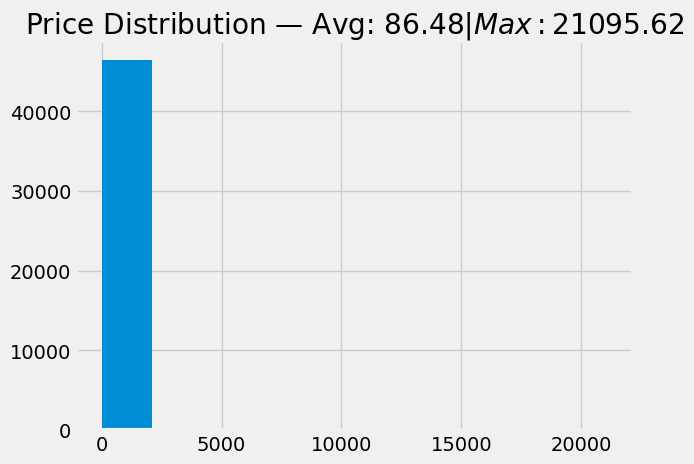

In [14]:
avg_price = sum(prices) / len(prices)
plt.title(f"Price Distribution — Avg: ${avg_price:.2f} | Max: ${max(prices):.2f}")
plt.hist(prices)
plt.show()

#### One thing we got from this histogram is that we dont need very large and pricy items because average price is below 100$ but we will still consider till 1000$ because we can see from the bar chat there are some spikes near $3000.

## Now lets store the dataset in Item format

In [15]:
import sys
sys.path.append("..")

In [16]:
from pricer.parser import parse
from pricer.items import Item

In [17]:
items = [parse(dp, "Appliances") for dp in tqdm(dataset)]
items = [item for item in items if item is not None]
print(f"Total Items: {len(items)} | Total Dataset: {len(dataset)}")

  0%|          | 0/94327 [00:00<?, ?it/s]

Total Items: 35168 | Total Dataset: 94327


In [18]:
items[0]

<Title: WD12X10327 Rack Roller and stud assembly Kit (4 Pack) by AMI PARTS Replaces AP4980629 PS3486910 1811003 | Category:  Appliances | Price 8.99>

In [19]:
prices = [item.price for item in items]
desc_length = [len(item.description) for item in items]

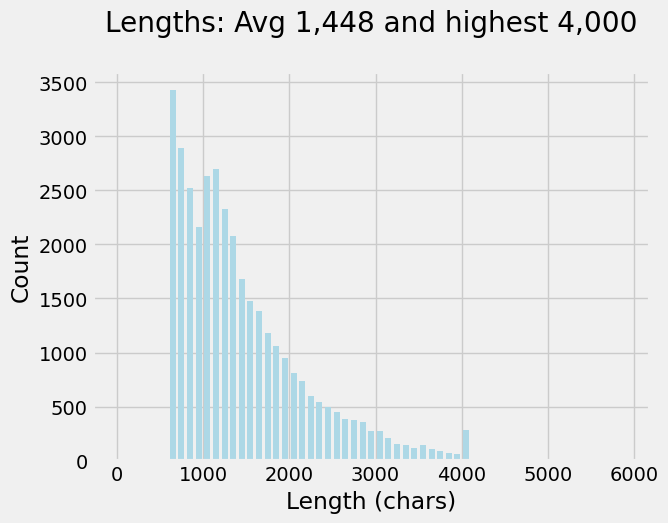

In [20]:
plt.title(f"Lengths: Avg {sum(desc_length)/len(desc_length):,.0f} and highest {max(desc_length):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.hist(desc_length, rwidth=0.7, color="lightblue", bins=range(0, 6000, 100))
plt.show()

In [21]:
max_len_item = max(desc_length)
max_len_item = items[desc_length.index(max_len_item)]

In [22]:
max_len_item

<Title: Polyester Dryer Vent Filters Replacement Part by Beaquicy Replacement for Better vent Indoor Dryer Vent Packs of 12 | Category:  Appliances | Price 14.88>

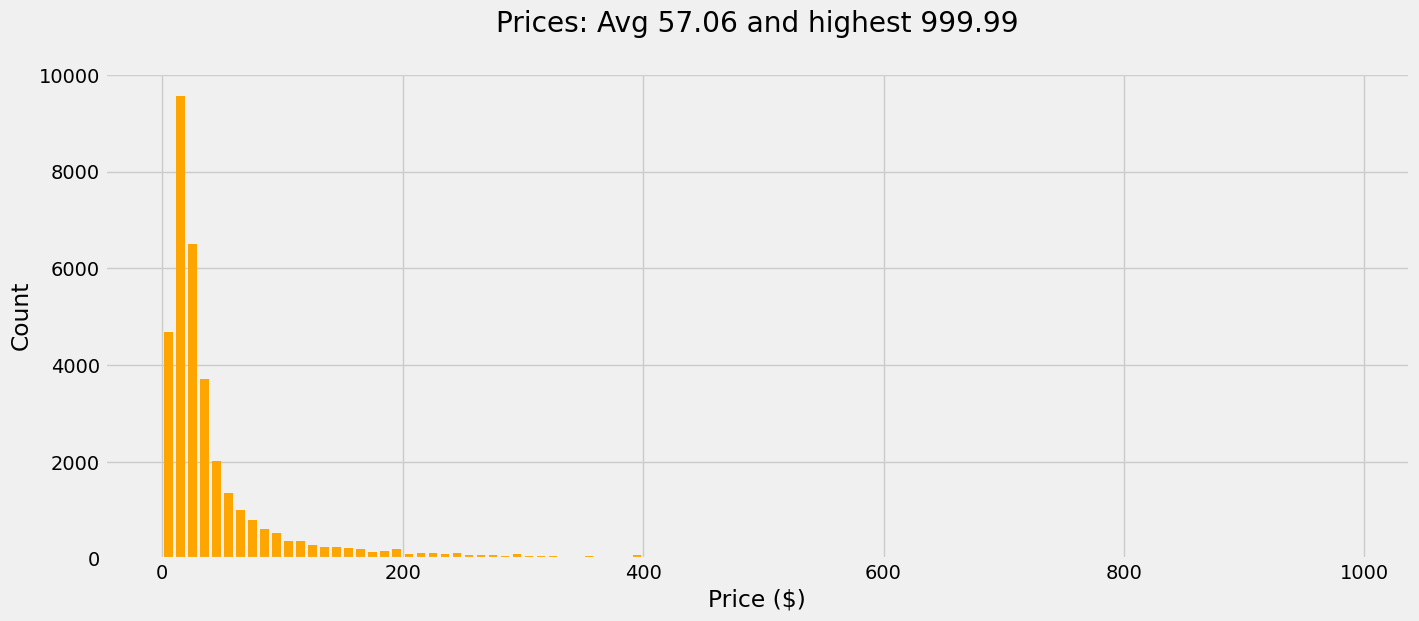

In [23]:
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.2f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="orange", bins=range(0, 1000, 10))
plt.show()

In [24]:
from pricer.loader import ItemLoader

In [25]:
loader = ItemLoader("Appliances")
items = loader.load()

Loading dataset Appliances


100%|██████████| 95/95 [00:03<00:00, 26.76it/s]


Completed Appliances with 35,168 datapoints in 0.1 mins


In [26]:
dataset_names = [
    "Automotive",
    "Electronics",
    "Office_Products",
    "Tools_and_Home_Improvement",
    "Cell_Phones_and_Accessories",
    "Toys_and_Games",
    "Appliances",
    "Musical_Instruments",
]

In [27]:
items = []
for dataset_name in dataset_names:
    items.extend(ItemLoader(dataset_name).load())

Loading dataset Automotive


100%|██████████| 2004/2004 [01:29<00:00, 22.40it/s]


Completed Automotive with 974,213 datapoints in 1.6 mins
Loading dataset Electronics


100%|██████████| 1611/1611 [00:54<00:00, 29.36it/s]


Completed Electronics with 464,008 datapoints in 1.1 mins
Loading dataset Office_Products


100%|██████████| 711/711 [00:28<00:00, 24.69it/s]


Completed Office_Products with 248,743 datapoints in 0.6 mins
Loading dataset Tools_and_Home_Improvement


100%|██████████| 1474/1474 [01:01<00:00, 23.99it/s]


Completed Tools_and_Home_Improvement with 552,060 datapoints in 1.2 mins
Loading dataset Cell_Phones_and_Accessories


raw/meta_categories/meta_Cell_Phones_and(…):   0%|          | 0.00/4.02G [00:00<?, ?B/s]

Generating full split:   0%|          | 0/1288490 [00:00<?, ? examples/s]

100%|██████████| 1289/1289 [00:36<00:00, 35.49it/s]


Completed Cell_Phones_and_Accessories with 242,345 datapoints in 3.7 mins
Loading dataset Toys_and_Games


raw/meta_categories/meta_Toys_and_Games.(…):   0%|          | 0.00/2.64G [00:00<?, ?B/s]

Generating full split:   0%|          | 0/890874 [00:00<?, ? examples/s]

100%|██████████| 891/891 [00:40<00:00, 21.77it/s]


Completed Toys_and_Games with 347,639 datapoints in 2.9 mins
Loading dataset Appliances


100%|██████████| 95/95 [00:03<00:00, 27.48it/s]


Completed Appliances with 35,168 datapoints in 0.2 mins
Loading dataset Musical_Instruments


raw/meta_categories/meta_Musical_Instrum(…):   0%|          | 0.00/632M [00:00<?, ?B/s]

Generating full split:   0%|          | 0/213593 [00:00<?, ? examples/s]

100%|██████████| 214/214 [00:08<00:00, 25.69it/s]


Completed Musical_Instruments with 68,912 datapoints in 0.7 mins


In [30]:
## Removing the duplicates
dup_titles = set()
dup_desc = set()
items = [item for item in tqdm(items) if not (item.title in dup_titles or dup_titles.add(item.title))]
items = [item for item in tqdm(items) if not (item.description in dup_desc or dup_desc.add(item.title))]
print(f"Total duplicates found: {len(dup_titles)+len(dup_desc)}")

  0%|          | 0/2888948 [00:00<?, ?it/s]

  0%|          | 0/2888948 [00:00<?, ?it/s]

Total duplicates found: 5777896


In [31]:
del dup_titles, dup_desc

In [32]:
print(f"After removing the duplicates length is : {len(items)}")

After removing the duplicates length is : 2888948


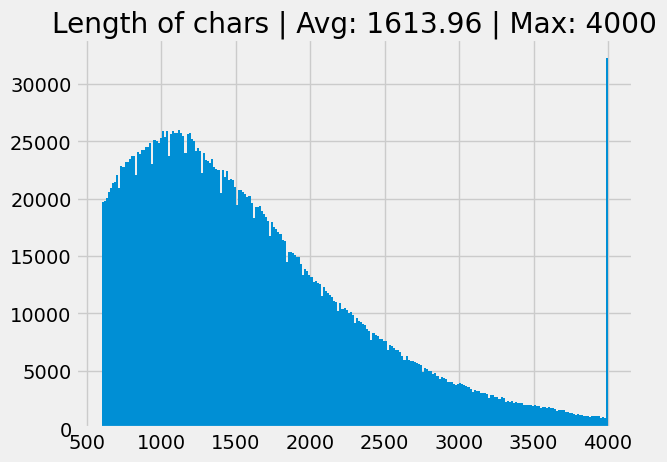

In [35]:
length_chars = [len(item.description) for item in items]
avg = sum(length_chars)/len(length_chars)
plt.hist(length_chars, bins = "auto")
plt.title(f"Length of chars | Avg: {avg:.2f} | Max: {max(length_chars)}")
plt.show()

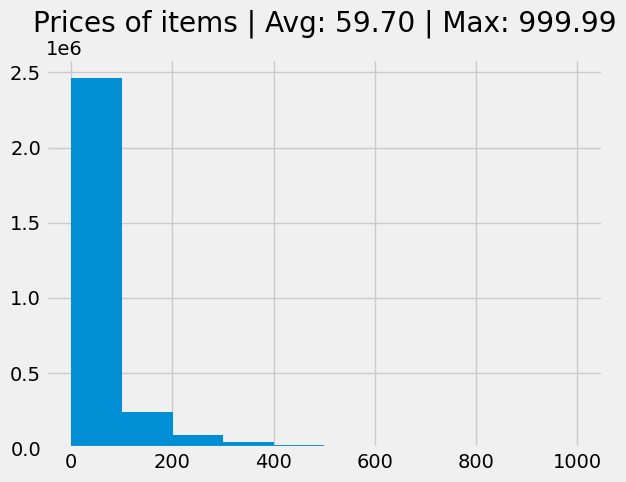

In [37]:
prices = [item.price for item in items]
avg = sum(prices)/len(prices)
plt.hist(prices)
plt.title(f"Prices of items | Avg: {avg:.2f} | Max: {max(prices)}")
plt.show()

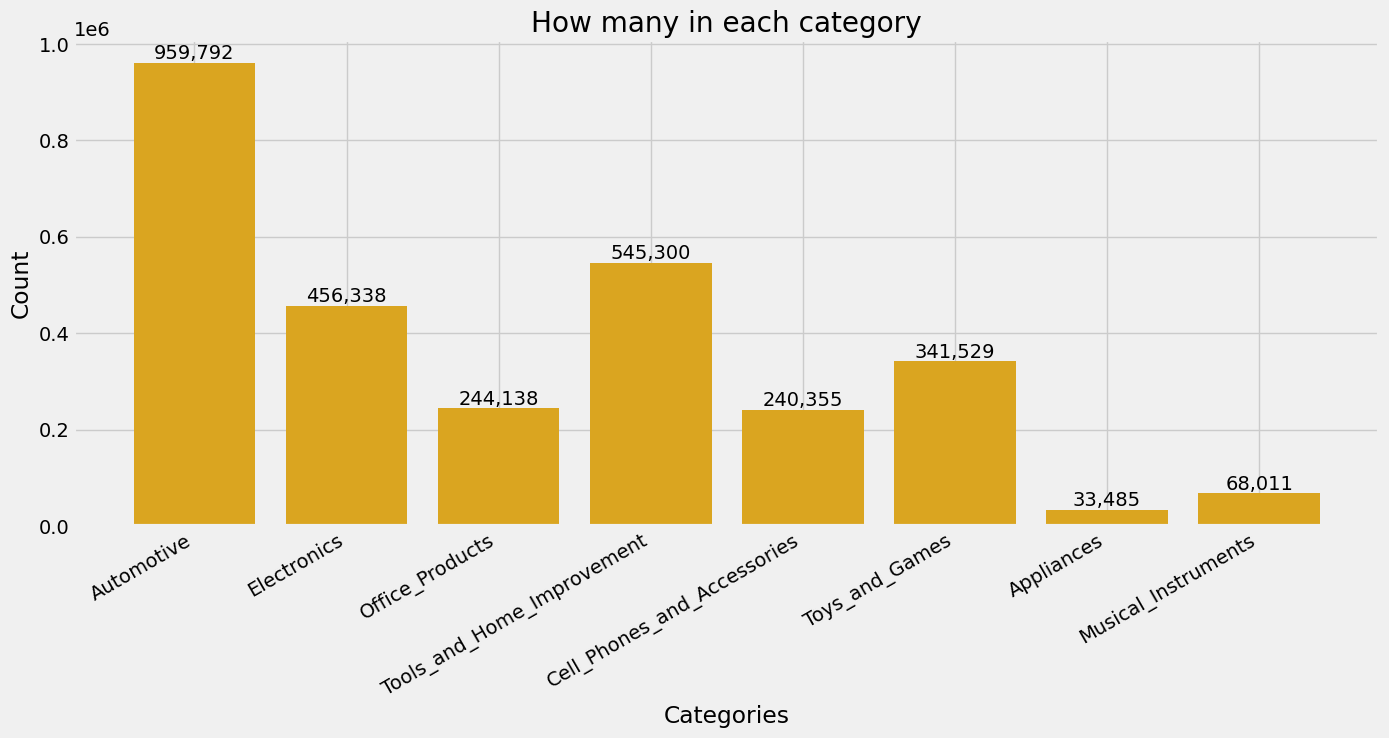

In [40]:
from collections import Counter
category_counts = Counter([item.category for item in items])

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')

for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

plt.show()

In [42]:
np.random.seed(42)
SIZE = 30000
prices = np.array([i.price for i in items], dtype = float)
cats = np.array([i.category for i in items])
# because the values are so big mathematical operations can suffer so for weighting just normalize them between 0 and 1
p = (prices - prices.min())/ (prices.max() - prices.min() + 1e-9)
w = p**2
w[cats== "Tools_and_Home_Improvement"] *= 0.5
w[cats == "Automotive"] *= 0.05
w = w / w.sum()
idx = np.random.choice(len(items), size = SIZE , replace = False , p=w)
sample = [items[i] for i in idx]

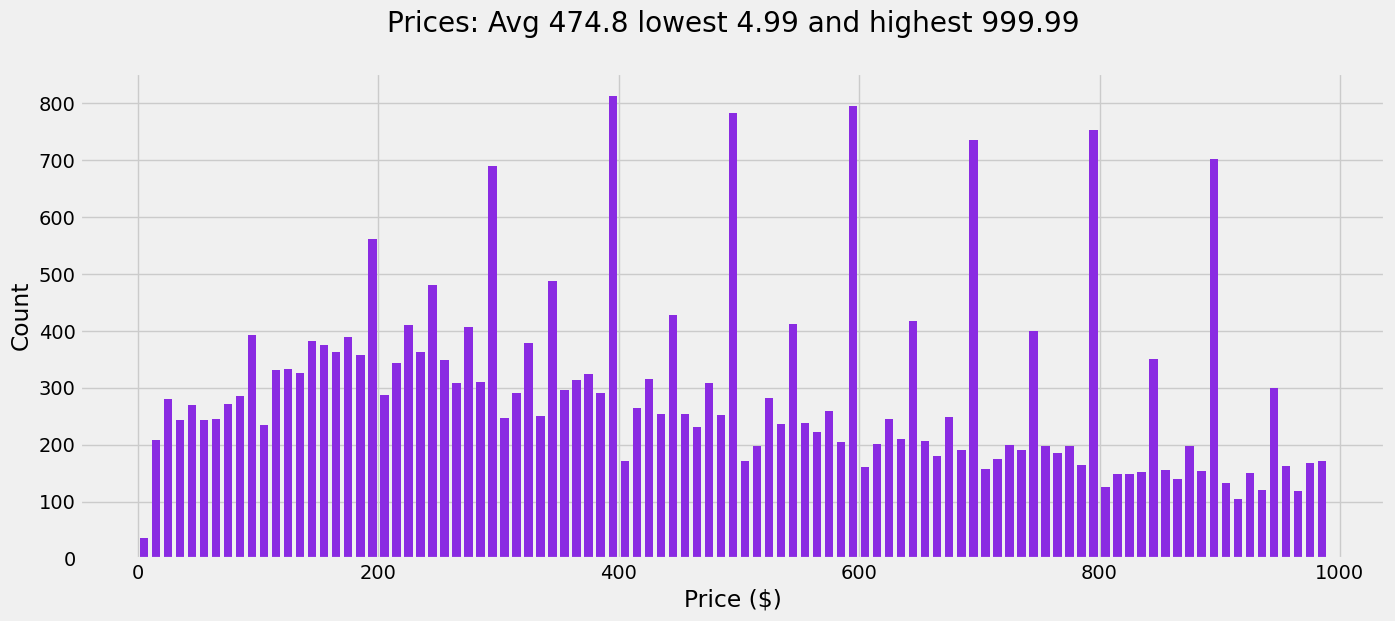

In [43]:
prices = [item.price for item in sample]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} lowest {min(prices):,} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

In [44]:
random.seed(42)
random.shuffle(sample)

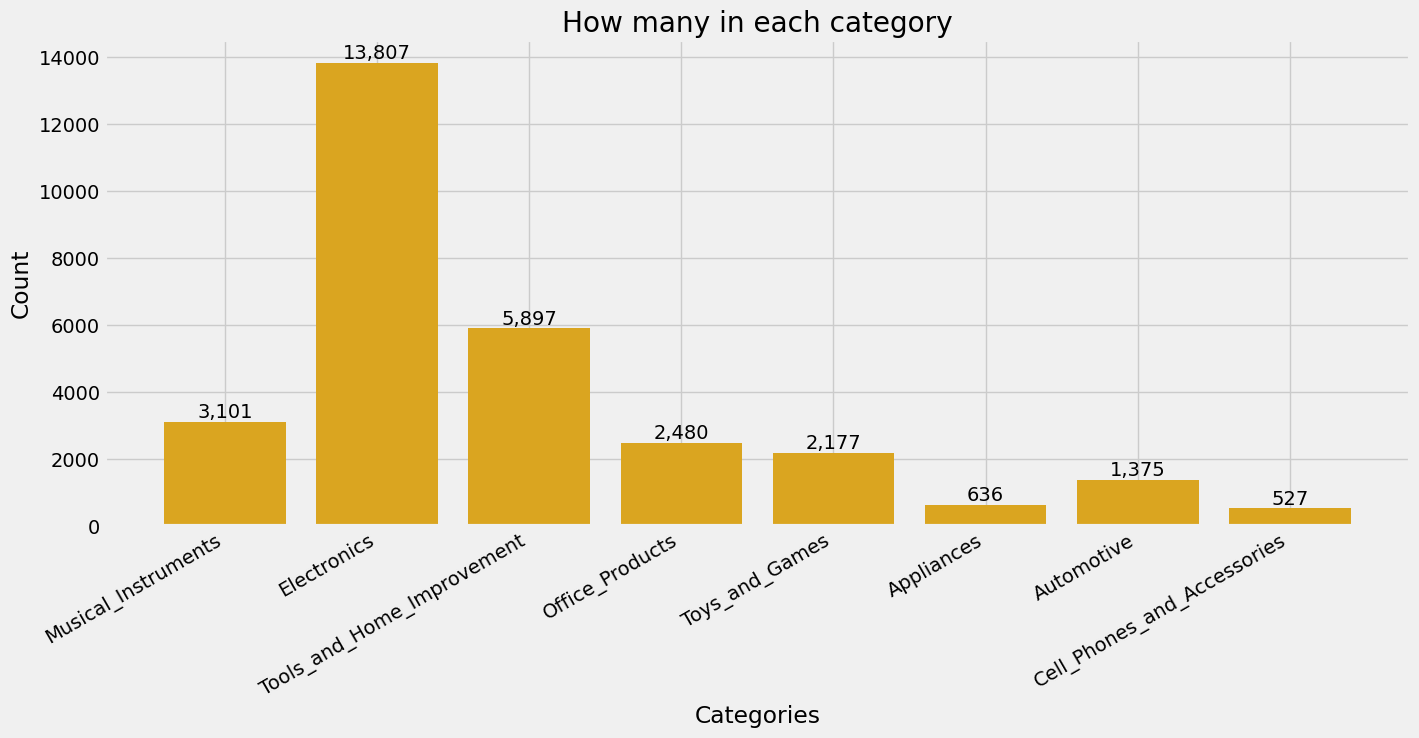

In [45]:
from collections import Counter
category_counts = Counter([item.category for item in sample])

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')

for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

plt.show()

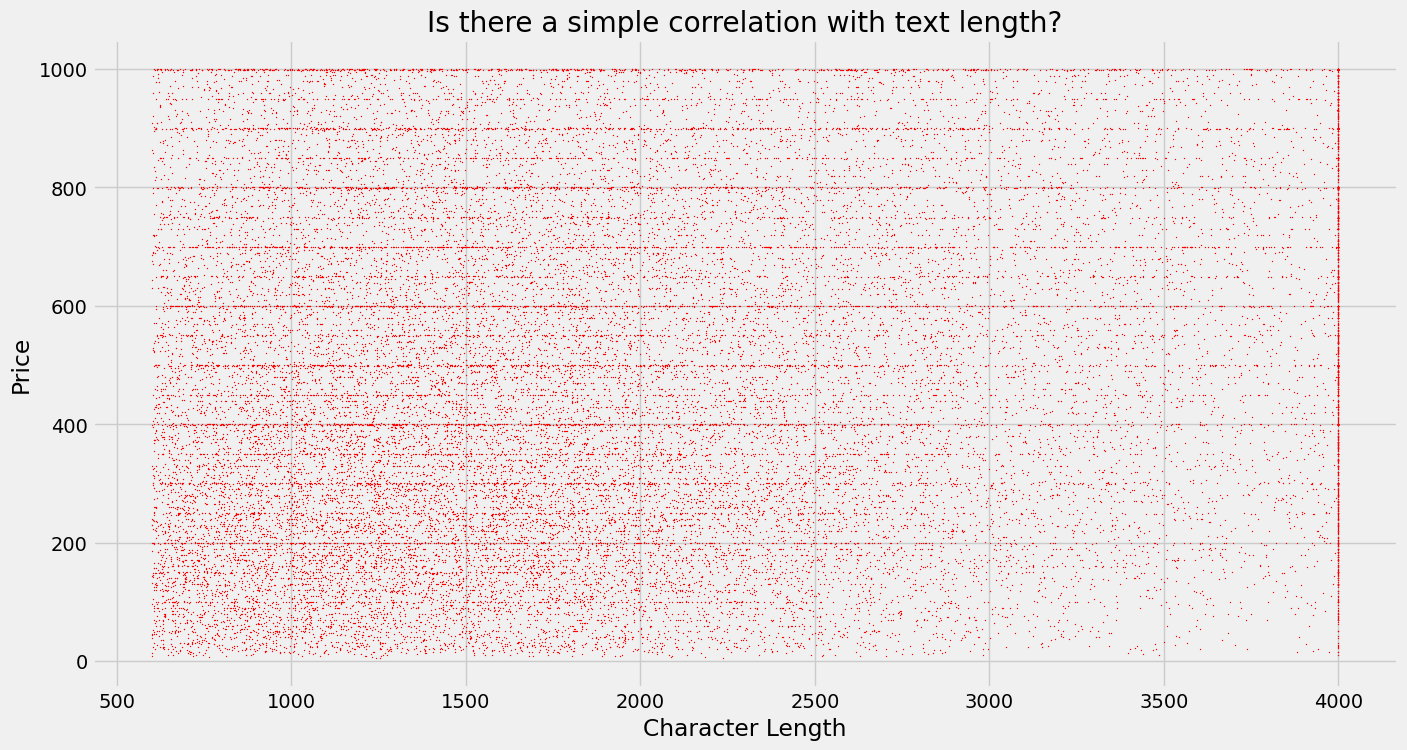

In [47]:
sizes = [len(item.description) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Character Length')
plt.ylabel('Price')
plt.title('Is there a simple correlation with text length?')

# Display the plot
plt.show()

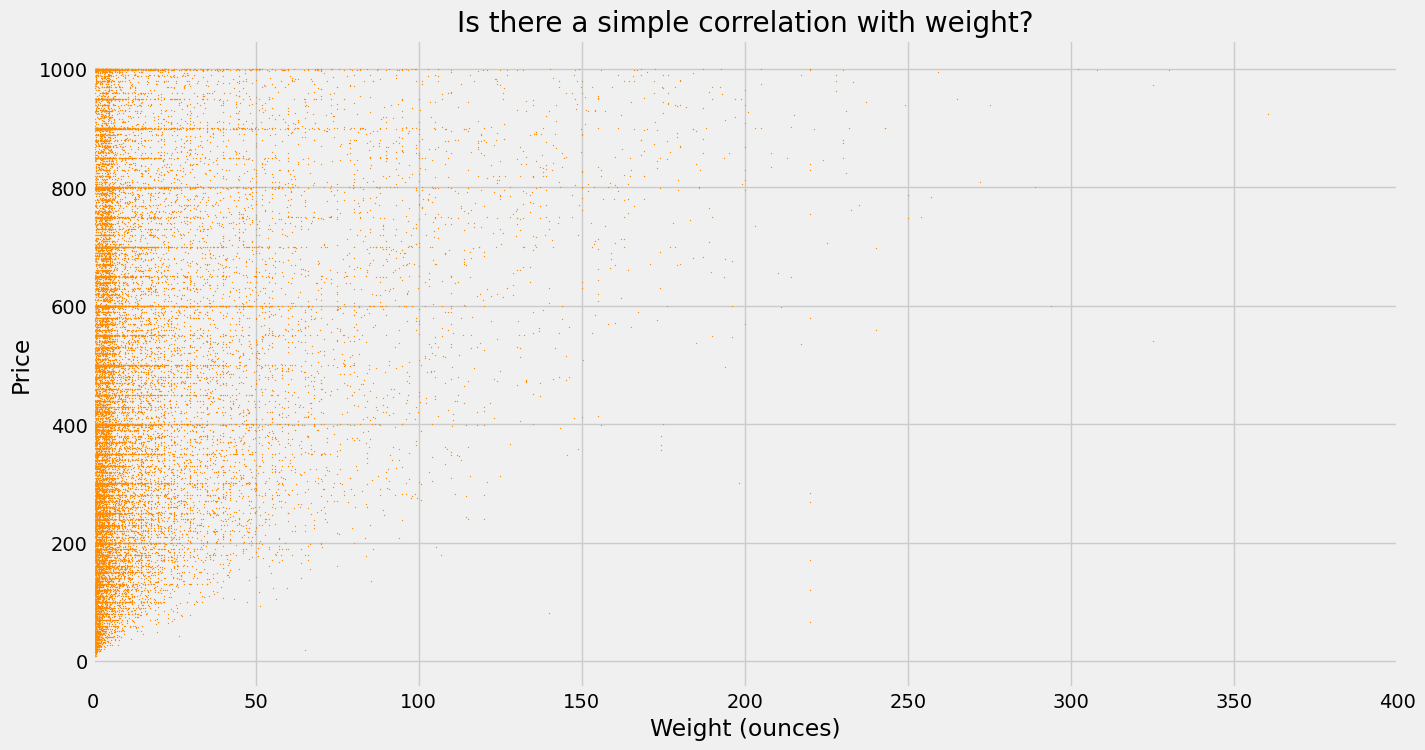

In [48]:
ounces = [item.weight for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(ounces, prices, s=0.2, color="darkorange")

# Add labels and title
plt.xlabel('Weight (ounces)')
plt.ylabel('Price')
plt.xlim(0, 400)
plt.title('Is there a simple correlation with weight?')

# Display the plot
plt.show()

In [60]:
from huggingface_hub import login
os.environ['HF_TOKEN'] = "ADD YOUR OWN API KEY : )"
login(os.environ['HF_TOKEN'], add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [61]:
username = "ujalaarshad17"
full = f"{username}/items_raw_full"
small = f"{username}/items_raw_small"

train = sample[:24000]
val = sample[24000:27000]
test = sample[27000:30000]

Item.push_to_hub(full, train, val, test)

train_small = train[:6000]
val_small = val[:1_000]
test_small = test[:1_000]

Item.push_to_hub(small, train_small, val_small, test_small)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/24 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            